# **LAB 4**

# OUTLIERS AND FILTERING

In [ ]:
 !pip install yfinance pandas pandas-ta matplotlib mplfinance prophet

JPMorgan Chase ($3,643,099,000 total assets)

Bank of America ($2,615,296,000 total assets)

Citibank ($1,760,921,000 total assets)

Wells Fargo Bank ($1,711,028,000 total assets)

U.S. Bank ($659,190,767 total assets)

In [ ]:
import yfinance as yf
from datetime import datetime, timedelta
# Define end_date and start_date (duration: 10 years)
end_date = datetime(2025, 10, 11)
start_date = end_date - timedelta(days=365 * 10)

# 10 tickers of America Banks (big bank)
us_bank_tickers = [
    "JPM",  # JPMorgan Chase
    "BAC",  # Bank of America
    "WFC",  # Wells Fargo
    "C",    # Citigroup
    "GS",   # Goldman Sachs
    "MS",   # Morgan Stanley
    "USB",  # U.S. Bancorp
    "PNC",  # PNC Financial Services
    "TFC",  # Truist Financial
    "COF"   # Capital One
]

data = yf.download(us_bank_tickers, start=start_date, end=end_date, auto_adjust=False)
data.tail(3)

[*********************100%***********************]  10 of 10 completed


Price       Adj Close                                                 \
Ticker            BAC          C         COF          GS         JPM   
Date                                                                   
2025-10-08  49.840000  96.126846  211.117081  776.510010  304.029999   
2025-10-09  49.790001  95.351471  209.941559  779.960022  305.529999   
2025-10-10  48.650002  93.373268  201.722824  764.359985  300.890015   

Price                                                                ...  \
Ticker              MS         PNC        TFC        USB        WFC  ...   
Date                                                                 ...   
2025-10-08  154.708145  188.430542  43.633648  46.990002  79.313004  ...   
2025-10-09  155.324402  188.935898  43.742390  47.099998  79.472168  ...   
2025-10-10  150.941086  182.277008  41.824646  45.279999  77.214043  ...   

Price         Volume                                                         \
Ticker           BAC         C      COF       GS      JPM       MS      PNC   
Date                                                                          
2025-10-08  24014200   8496000  2409800  1939300  6489900  4038600  1630100   
2025-10-09  21816900  11300600  2756500  1575000  7060300  6092600  1899500   
2025-10-10  31831900  18619500  4641200  2457900  8597400  5531700  2208800   

Price                                    
Ticker          TFC       USB       WFC  
Date                                     
2025-10-08  6915600   5315700  11277400  
2025-10-09  6963400   7011500   8432200  
2025-10-10  8512300  12468400  16004300  

[3 rows x 60 columns]

In [ ]:
import pandas as pd
# CONVERT FROM WIDE → LONG (Flat DataFrame)

# Stack by stock code (Ticker)
data_stacked = data.stack(level='Ticker')

# Convert Date & Ticker into columns
data_long = data_stacked.reset_index()

# Remove axis names
data_long = data_long.rename_axis(None, axis=1)

# Standardize column names
data_long = data_long.rename(columns={
    'Adj Close': 'Adjusted Close',
    'Ticker': 'Global_Bank',
})

# Keep and sort necessary columns
ordered_columns = ['Date', 'Global_Bank', 'Open', 'High', 'Low', 'Close', 'Adjusted Close', 'Volume']
existing_columns = [col for col in ordered_columns if col in data_long.columns]
data_final = data_long[existing_columns]

# Convert date type (Date) and reorder
data_final['Date'] = pd.to_datetime(data_final['Date'], errors='coerce')
data_final = data_final.sort_values(['Global_Bank', 'Date']).reset_index(drop=True)

# The final result is a flat DataFrame
print("\n DataFrame after conversion (flat):\n")
print(data_final.head())
print("\n Check index:", data_final.index)
print("\n Data types:")
print(data_final.dtypes)


/tmp/ipython-input-1848554707.py:5: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data_stacked = data.stack(level='Ticker')



 DataFrame after conversion (flat):

        Date Global_Bank       Open       High        Low      Close  \
0 2015-10-14         BAC  15.770000  15.920000  15.550000  15.640000   
1 2015-10-15         BAC  15.810000  16.280001  15.720000  16.190001   
2 2015-10-16         BAC  16.290001  16.290001  16.030001  16.120001   
3 2015-10-19         BAC  16.000000  16.209999  15.980000  16.139999   
4 2015-10-20         BAC  16.160000  16.290001  16.100000  16.200001   

   Adjusted Close     Volume  
0       12.591781  122272400  
1       13.034586  127028800  
2       12.978231   66989500  
3       12.994331   62953500  
4       13.042639   50797800  

 Check index: RangeIndex(start=0, stop=25130, step=1)

 Data types:
Date              datetime64[ns]
Global_Bank               object
Open                     float64
High                     float64
Low                      float64
Close                    float64
Adjusted Close           float64
Volume                     int64
dtype: obj

With the data is 10 of the largest bank in US, some problem we might encounter when detect outliers are:

**Thinly Traded Stocks** => Won't be the problems since these 10 stocks are:
 + Trade millions of shares per day
 + Have extremely tight bid–ask spreads
 + Are included in major indices (S&P 500, Dow)
 + Have billions of dollars in daily trading value

**Market Crashes**: With the time range is 10 years, this might be happen since bank stocks are highly sensitive to economic crises, so their share prices dropped sharply during major market-wide crashes

With that, we will look for outlier


Brute Force Review helps looking for
- Missing values
- Non-positive prices
- Duplicate rows
- Extreme daily jumps

In [ ]:
import numpy as np

def brute_force_review(df):
    report = {}

    # 1. Missing values
    report["missing_values_each_column"] = df.isna().sum().to_dict()

    # Rows containing ANY NaN
    report["rows_with_na"] = df[df.isna().any(axis=1)].index.tolist()

    # 2. Non-positive prices
    price_cols = ["Open", "High", "Low", "Close"]
    bad_price_mask = (df[price_cols] <= 0).any(axis=1)
    report["rows_non_positive_prices"] = df[bad_price_mask].index.tolist()

    # 3. Duplicate rows
    report["duplicate_rows"] = df[df.duplicated()].index.tolist()

    # 4. Extreme daily jumps (computed per stock)
    extreme_jump_rows = []
    for bank, g in df.groupby("Global_Bank"):
        g_sorted = g.sort_values("Date")
        pct = g_sorted["Close"].pct_change()
        extreme_rows = g_sorted.index[abs(pct) > 0.15].tolist()  # > 15% jump
        extreme_jump_rows.extend(extreme_rows)

    report["extreme_jumps_over_15pct"] = extreme_jump_rows

    return report


Based on the report, we can see there a large number of sample that have enormous price jumps (over 15%) which is really rare and could be outlier, this will be encountered later

In [ ]:
report = brute_force_review(data_final)
report

{'missing_values_each_column': {'Date': 0,
  'Global_Bank': 0,
  'Open': 0,
  'High': 0,
  'Low': 0,
  'Close': 0,
  'Adjusted Close': 0,
  'Volume': 0},
 'rows_with_na': [],
 'rows_non_positive_prices': [],
 'duplicate_rows': [],
 'extreme_jumps_over_15pct': [1110,
  1111,
  1117,
  3619,
  3623,
  3624,
  6137,
  6139,
  6143,
  6152,
  7307,
  8649,
  11162,
  13674,
  13675,
  13676,
  13682,
  16189,
  18697,
  18702,
  18708,
  19455,
  21214,
  23726]}

Visualization: quick plots

**Price Chart** — Detecting 15% Price Jumps
- Mark any trading day where the Close price moves more than ±15% compared to the previous day, such jumps are uncommon for banking stocks.

- These points may indicate: data errors, major market events, panic or abnormal market reactions

**Volume Chart** — Detecting Abnormal Volume Spikes

- Compare trading volume with the 20–60 day baseline.

- A point is considered abnormal if: The volume spikes sharply, far above the 20–60 day average, Or the price shows a strong movement (e.g., ±15%) but volume does NOT increase.(large price moves typically come with high volume)

**Return Chart** — Detecting Extreme Daily Returns
- Mark points where the return exceeds ±15%.
- A ±15% return is rare for banking stocks, so such points usually indicate: data issues, significant news or events, market anomalies.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_outliers_with_marks(data_final, bank_name, threshold=0.15):
    # Filter by bank
    df = data_final[data_final["Global_Bank"] == bank_name].copy()
    df = df.sort_values("Date")

    # Compute returns
    df["Return"] = df["Close"].pct_change()

    # Flag outliers
    df["Outlier"] = abs(df["Return"]) > threshold
    outliers = df[df["Outlier"]]

    # --- Price chart ---
    plt.figure(figsize=(14,4))
    sns.lineplot(data=df, x="Date", y="Close")
    plt.scatter(outliers["Date"], outliers["Close"], color="red", s=40, label="Outlier")
    plt.title(f"Price Chart – {bank_name} (Outliers Highlighted)")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.show()

    # --- Volume chart ---
    plt.figure(figsize=(14,4))
    sns.lineplot(data=df, x="Date", y="Volume")
    plt.scatter(outliers["Date"], outliers["Volume"], color="red", s=40, label="Outlier")
    plt.title(f"Volume Chart – {bank_name} (Outliers Highlighted)")
    plt.xlabel("Date")
    plt.ylabel("Volume")
    plt.legend()
    plt.show()

    # --- Return scatter plot + outliers ---
    plt.figure(figsize=(14,4))
    sns.scatterplot(data=df, x="Date", y="Return")
    plt.scatter(outliers["Date"], outliers["Return"], color="red", s=50, label="Outlier")
    plt.axhline(threshold, color="gray", linestyle="--")
    plt.axhline(-threshold, color="gray", linestyle="--")
    plt.title(f"Daily Returns – {bank_name} (Outliers in Red)")
    plt.xlabel("Date")
    plt.ylabel("Return")
    plt.legend()
    plt.show()


In [ ]:
for bank in data_final["Global_Bank"].unique():
    visualize_outliers_with_marks(data_final, bank)


-- Covid

Due to Covid, banks stocks face enormous down drop


-- TFC 2023

Shares of the super-regional bank Truist Financial (TFC +0.63%) fell close to 30% through the first six months of 2023, according to data compiled by S&P Global Market Intelligence. The main reason for the decline largely has to do with the fallout from the banking crisis earlier this year.

-- COF

In late 2024, Capital One Financial (COF) stock showed signs of being a potentially valuable investment, with some analysts and investors noting attractive valuation metrics like a forward P/E ratio of 11.18. However, the stock was also subject to insider selling activity, and the overall banking sector faced macroeconomic challenges and trends towards digital transformation (Ở đây vẫn chưa giải quyết được về COF

Since we use data for regression, unless the data is wrong then we don't need to delete it since its real event and data can learn from it

Another way: Rule based

In [ ]:
def rule_based_outliers_multibank(df, return_threshold=0.15, volume_mult=1.2, rolling_window=50):
    df = df.copy()

    # Sort dữ liệu theo cổ phiếu và ngày
    df = df.sort_values(["Global_Bank", "Date"])

    # Khởi tạo cột
    df["ret"] = df.groupby("Global_Bank")["Close"].pct_change()

    # Rolling median volume theo mỗi cổ phiếu
    df["vol_med"] = df.groupby("Global_Bank")["Volume"].transform(lambda x: x.rolling(rolling_window).median())

    # Flag return vượt ngưỡng
    df["flag_return"] = abs(df["ret"]) > return_threshold

    # Flag volume spike
    df["flag_volume_spike"] = df["Volume"] > volume_mult * df["vol_med"]

    # Outlier do dữ liệu sai (return lớn nhưng volume không spike)
    df["possible_bad_data"] = df["flag_return"] & (~df["flag_volume_spike"])

    # Outlier do sự kiện thật (return lớn và volume spike)
    df["likely_real_event"] = df["flag_return"] & df["flag_volume_spike"]

    return df


In [ ]:
df_outliers = rule_based_outliers_multibank(data_final)

# Date suspected is wrong
df_outliers[df_outliers["possible_bad_data"]][["Date","Global_Bank","Close","Volume","ret"]]


,Date,Global_Bank,Close,Volume,ret


In [ ]:
# Date suspected true event
df_outliers[df_outliers["likely_real_event"]][["Date","Global_Bank","Close","Volume","ret"]]

,Date,Global_Bank,Close,Volume,ret
1110,2020-03-13,BAC,24.160000,128357400,0.177962
1111,2020-03-16,BAC,20.440001,121688800,-0.153973
1117,2020-03-24,BAC,21.030001,147882400,0.163164
3619,2020-03-09,C,51.369999,35625600,-0.161717
3623,2020-03-13,C,51.040001,40519800,0.179843
3624,2020-03-16,C,41.189999,35133800,-0.192986
6137,2020-03-16,COF,55.450001,6562300,-0.238742
6139,2020-03-18,COF,44.299999,12148700,-0.178412
6143,2020-03-24,COF,50.910000,5553300,0.187544
6152,2020-04-06,COF,49.419998,5842700,0.169151


Về cơ bản Outlier còn thiếu phần giải thích rule_base và cách xử lý một vài điểm (COF)

# Regression

Check for corelation

Based on the heatmap we can see that Open, High, Low, Close all have the same correlation of 1 since they tend to go together
On the other hand volume did not have such a great corellation than others
=> Put a focus on BAC for now since its volume have the best correlation with other attribute

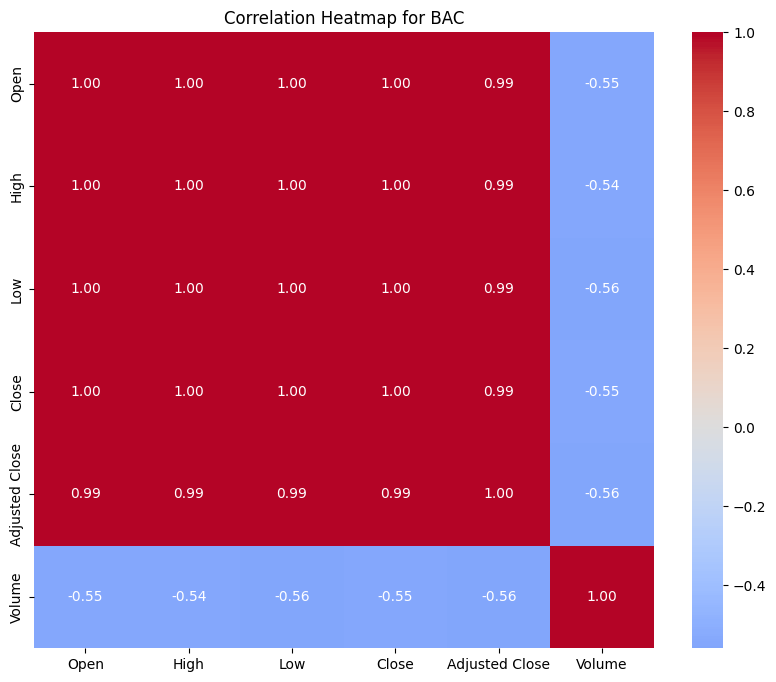

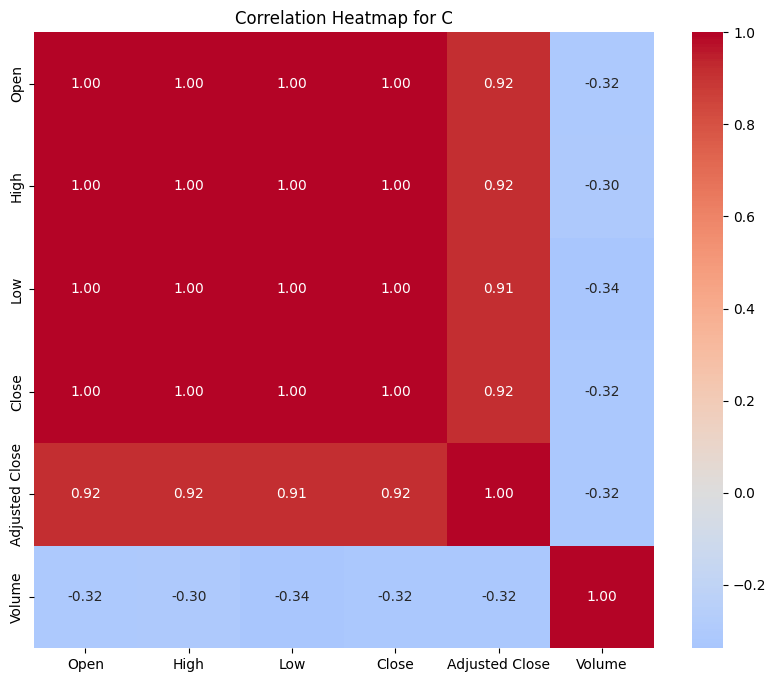

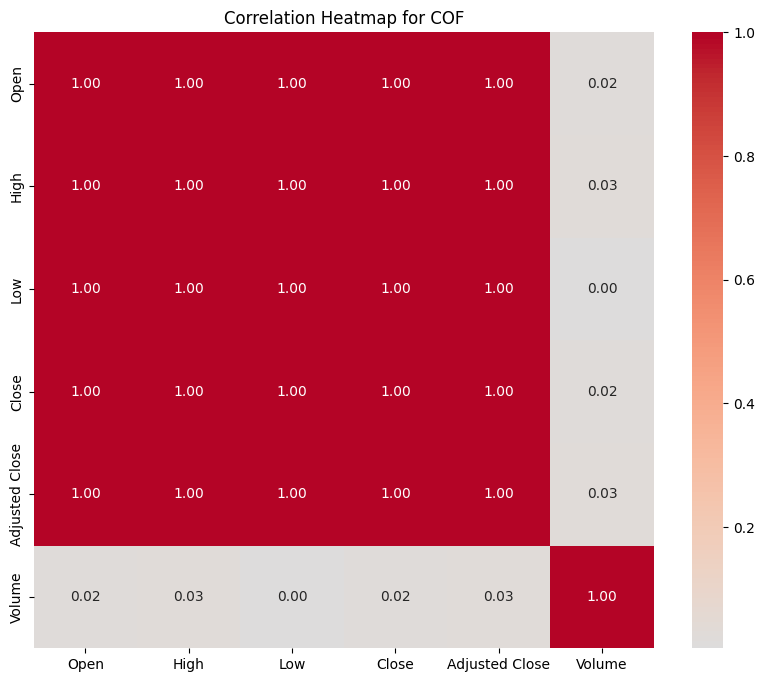

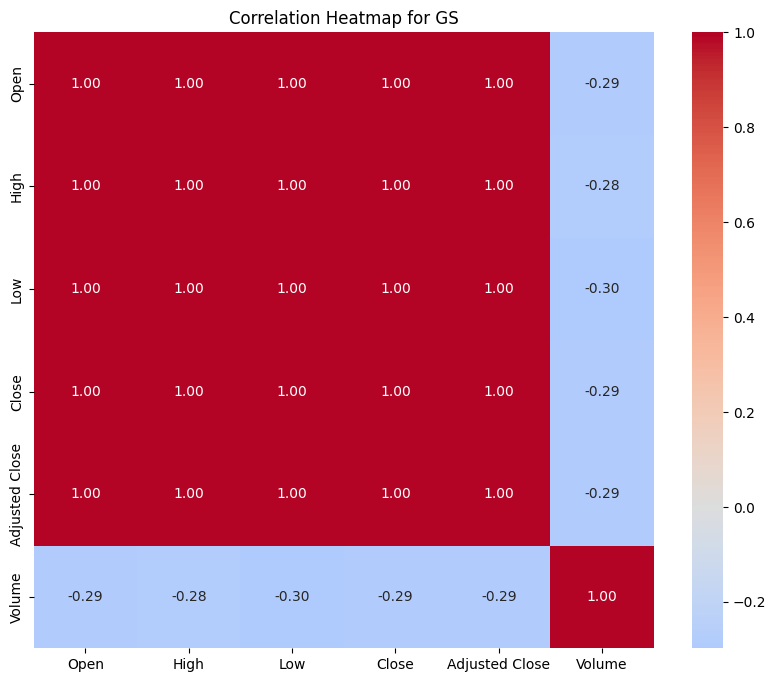

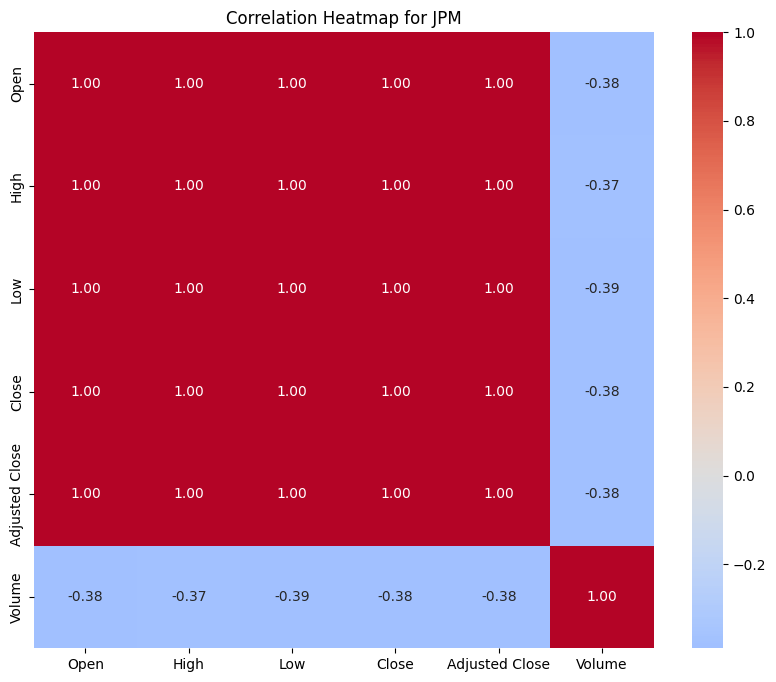

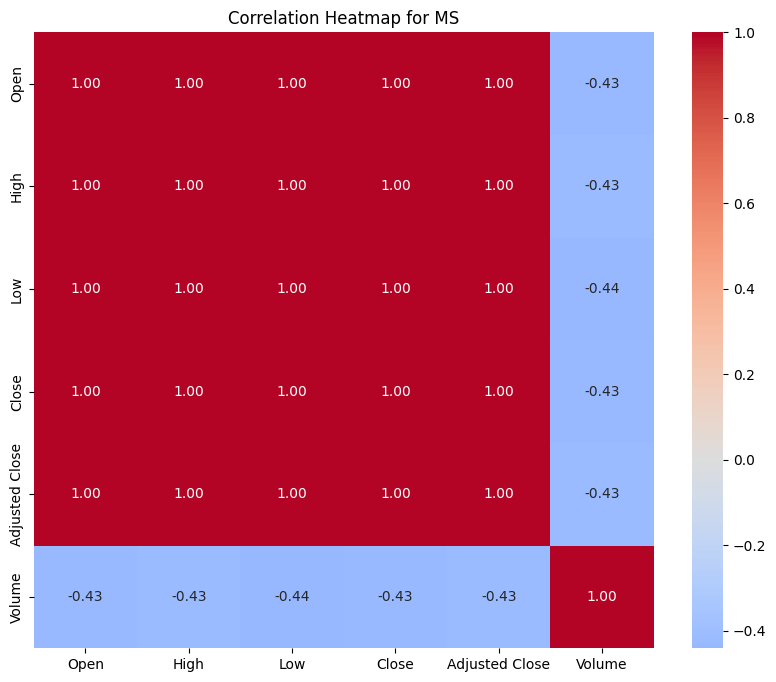

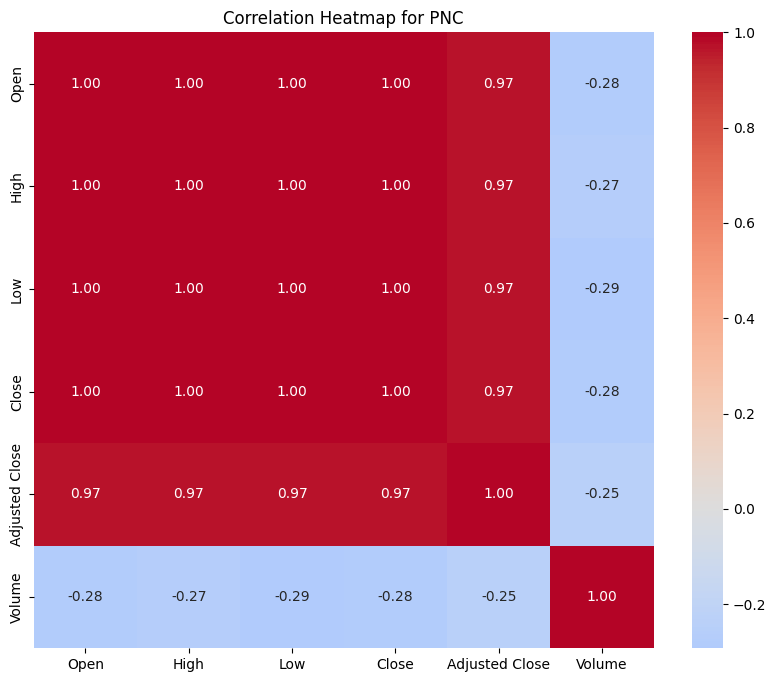

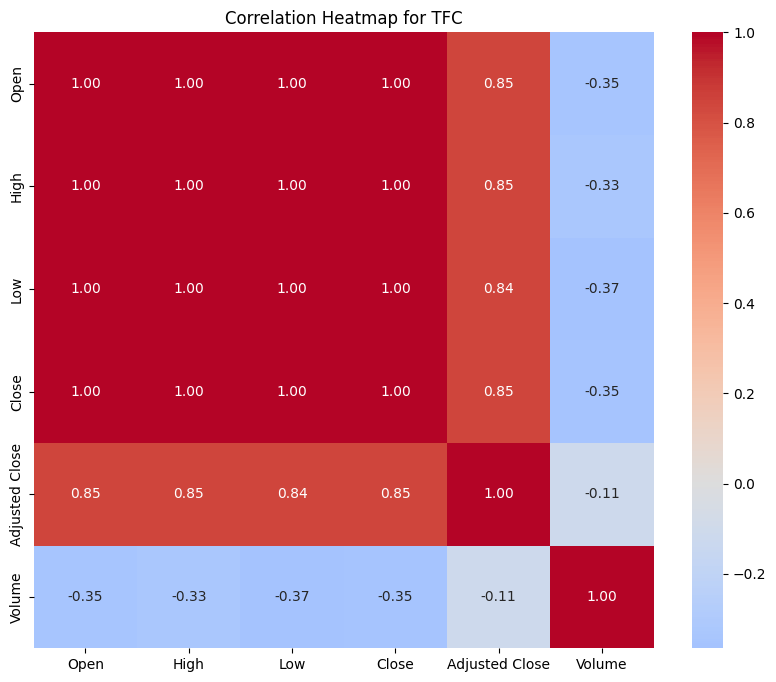

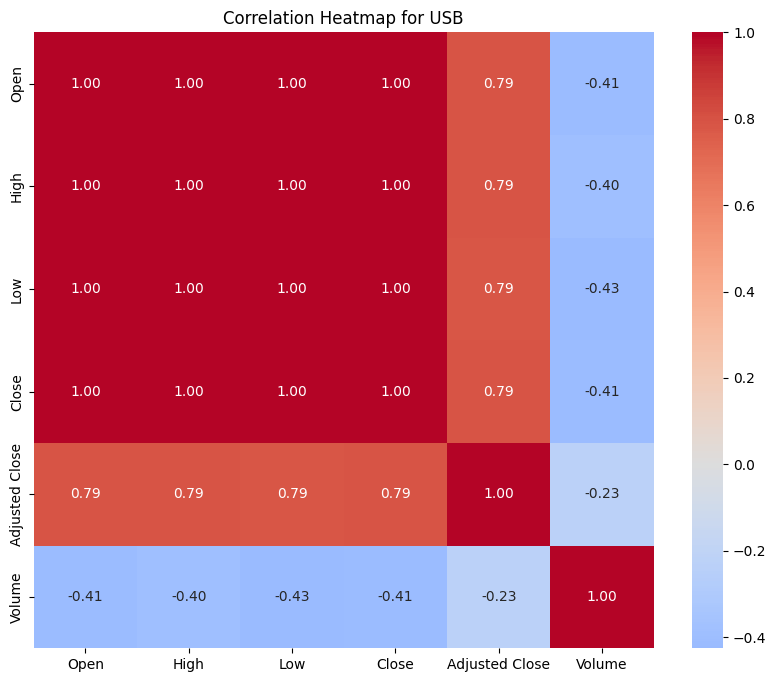

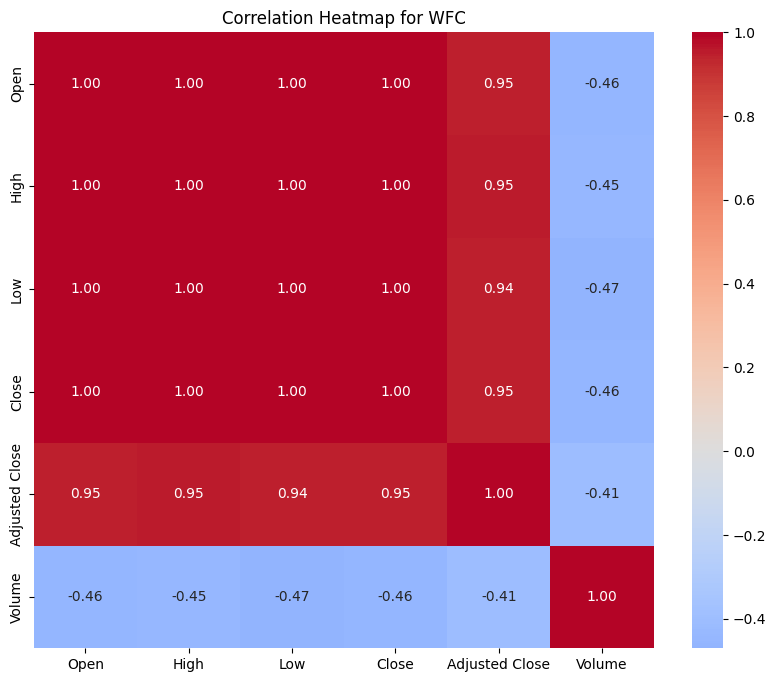

In [ ]:
# Copy data
df = data_final.copy()

# List of numeric columns
numeric_cols = ["Open", "High", "Low", "Close", "Adjusted Close", "Volume"]

for bank, g in df.groupby("Global_Bank"):
    df_numeric = g[numeric_cols]

    # Correlation matrix
    corr_matrix = df_numeric.corr()

    # Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
    plt.title(f"Correlation Heatmap for {bank}")
    plt.show()


## Using Open price to predict High price with BAC ticker

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Select necessary columns
df = data_final[['Global_Bank', 'Open', 'High']].copy()

# Filter for BAC
df_bac = df[df['Global_Bank'] == 'BAC']

X = df_bac[['Open']]  # feature
y = df_bac['High']    # target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

# Print model coefficients
print(f"Coefficient: {model.coef_[0]:.4f}")
print(f"Intercept: {model.intercept_:.4f}")

y_pred = model.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.6f}")
print(f"R^2 Score: {r2:.4f}")


Coefficient: 1.0078
Intercept: 0.0878
Mean Squared Error: 0.096715
R^2 Score: 0.9988


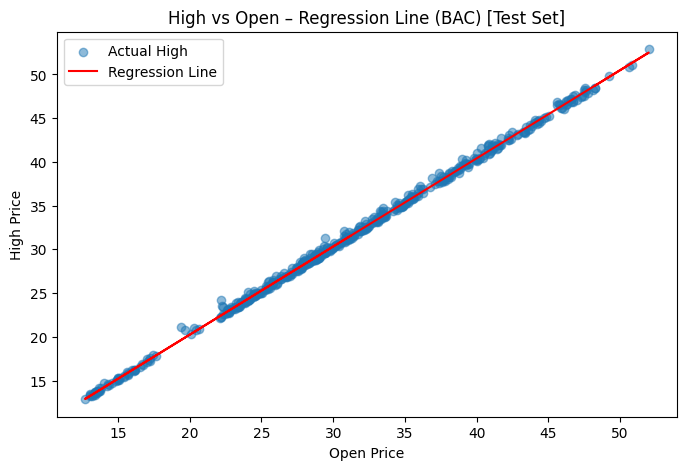

In [ ]:
# Scatter actual vs prediction

plt.figure(figsize=(8,5))
plt.scatter(X_test, y_test, alpha=0.5, label='Actual High')
plt.plot(X_test, y_pred, color='red', label='Regression Line')
plt.xlabel('Open Price')
plt.ylabel('High Price')
plt.title('High vs Open – Regression Line (BAC) [Test Set]')
plt.legend()
plt.show()

As said above, Open and High have a perfect corelation, using Regression will have a significant result

## Using volume to predict close price with BAC ticker

In [ ]:
# Select necessary columns
df = data_final[['Global_Bank', 'Close', 'Volume']].copy()

# Filter for BAC
df_bac = df[df['Global_Bank'] == 'BAC']

# Feature and target
X = df_bac[['Volume']]  # predictor
y = df_bac['Close']     # target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Build model
model = LinearRegression()
model.fit(X_train, y_train)

# Print model parameters
print(f"Coefficient: {model.coef_[0]:.6f}")
print(f"Intercept: {model.intercept_:.6f}")

# Predictions
y_pred = model.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.8f}")
print(f"R^2 Score: {r2:.6f}")

Coefficient: -0.000000
Intercept: 40.180059
Mean Squared Error: 53.48019789
R^2 Score: 0.316659


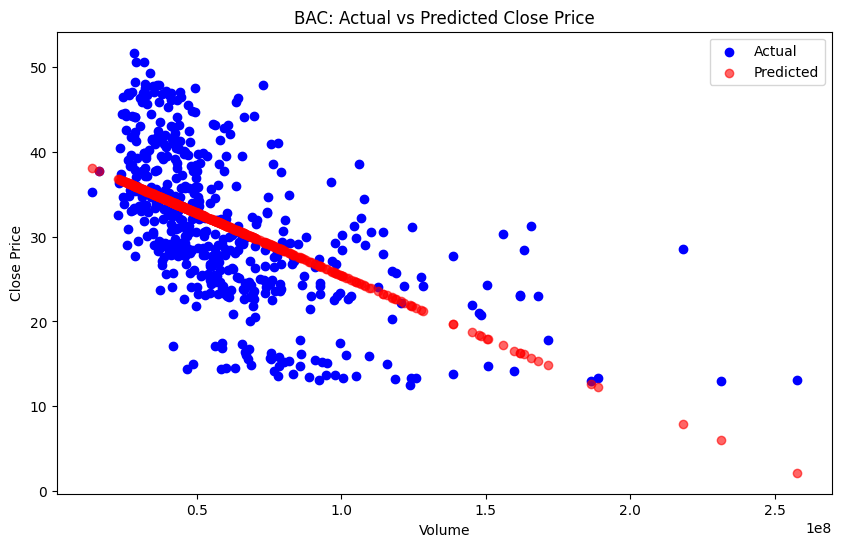

In [ ]:
# Plot actual vs predicted
plt.figure(figsize=(10,6))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_pred, color='red', label='Predicted', alpha=0.6)
plt.xlabel('Volume')
plt.ylabel('Close Price')
plt.title('BAC: Actual vs Predicted Close Price')
plt.legend()
plt.show()

As mentioned before, volume did not operate a good result in predicting close price (or Open, High, Low)

## Do volume creat a significant on return

In [ ]:
df = data_final.copy()

# Tính daily return from each bank
df['return_abs'] = (
    df.groupby('Global_Bank')['Close']
      .pct_change()
      .abs()
)

df.head()


,Date,Global_Bank,Open,High,Low,Close,Adjusted Close,Volume,return_abs
0,2015-10-14,BAC,15.770000,15.920000,15.550000,15.640000,12.591781,122272400,NaN
1,2015-10-15,BAC,15.810000,16.280001,15.720000,16.190001,13.034586,127028800,0.035166
2,2015-10-16,BAC,16.290001,16.290001,16.030001,16.120001,12.978231,66989500,0.004324
3,2015-10-19,BAC,16.000000,16.209999,15.980000,16.139999,12.994331,62953500,0.001241
4,2015-10-20,BAC,16.160000,16.290001,16.100000,16.200001,13.042639,50797800,0.003718


In [ ]:
# Filter BAC stock
df_bac = df[df['Global_Bank'] == 'BAC'].copy()

# Remove the first row where return_abs is NaN
df_bac = df_bac.dropna(subset=['return_abs'])

# Features and target
X = df_bac[['Volume']]           # Predictor
y = df_bac['return_abs']         # Target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Build model
model = LinearRegression()
model.fit(X_train, y_train)

# Print model parameters
print(f"Coefficient: {model.coef_[0]:.6f}")
print(f"Intercept: {model.intercept_:.6f}")

# Predictions
y_pred = model.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.8f}")
print(f"R^2 Score: {r2:.6f}")


Coefficient: 0.000000
Intercept: 0.001348
Mean Squared Error: 0.00019802
R^2 Score: 0.159719


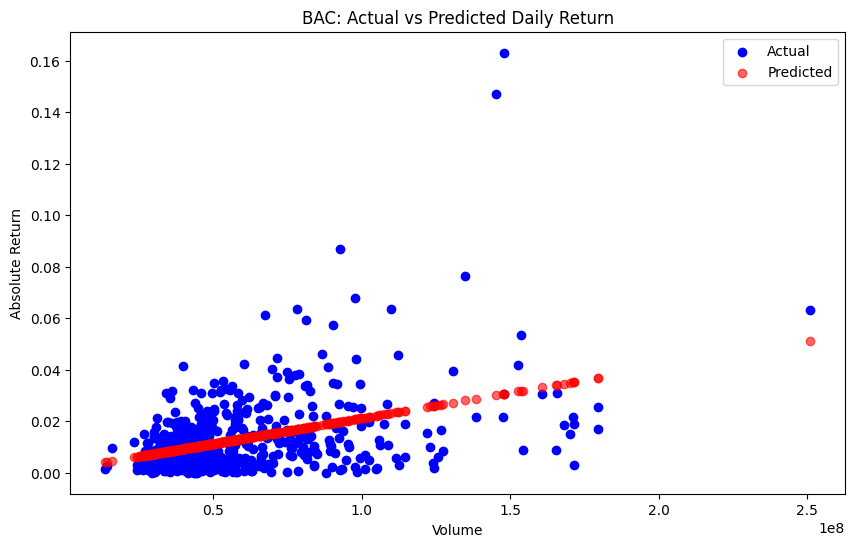

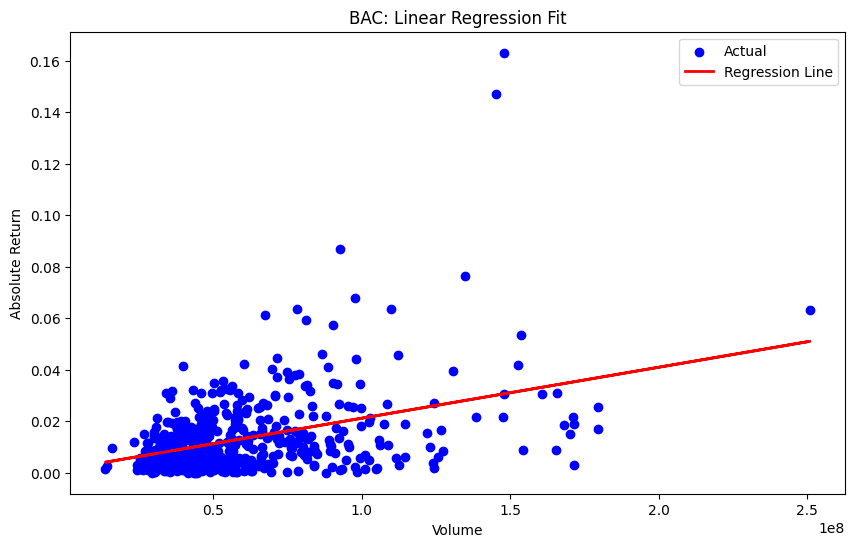

In [ ]:
# Scatter plot actual vs predicted
plt.figure(figsize=(10,6))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_pred, color='red', label='Predicted', alpha=0.6)
plt.xlabel('Volume')
plt.ylabel('Absolute Return')
plt.title('BAC: Actual vs Predicted Daily Return')
plt.legend()
plt.show()

# Hoặc scatter + regression line
plt.figure(figsize=(10,6))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Regression Line')
plt.xlabel('Volume')
plt.ylabel('Absolute Return')
plt.title('BAC: Linear Regression Fit')
plt.legend()
plt.show()


As we saw about, in bank volume didn't create a great impact on stock price, there are so many situation that affect bank stock price, and volume just have a small effect on it

## Do high volume in a day affect Daily Volatility ?

In [ ]:
df = data_final.copy()
df['daily_volatility_percent'] = 100*(df['High'] - df['Low']) / df['Open']

In [ ]:
# Choose the attribute
df = df[['Global_Bank', 'Volume', 'daily_volatility_percent']]

# BAC
df_bac = df[df['Global_Bank'] == 'BAC']

# Feature & target
X = df_bac[['Volume']]
y = df_bac['daily_volatility_percent']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Build Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Print coefficients
print(f"Coefficient: {model.coef_[0]:.6f}")
print(f"Intercept: {model.intercept_:.6f}")

# Predictions
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.8f}")
print(f"R^2 Score: {r2:.6f}")

Coefficient: 0.000000
Intercept: 1.104582
Mean Squared Error: 1.15938759
R^2 Score: 0.298148


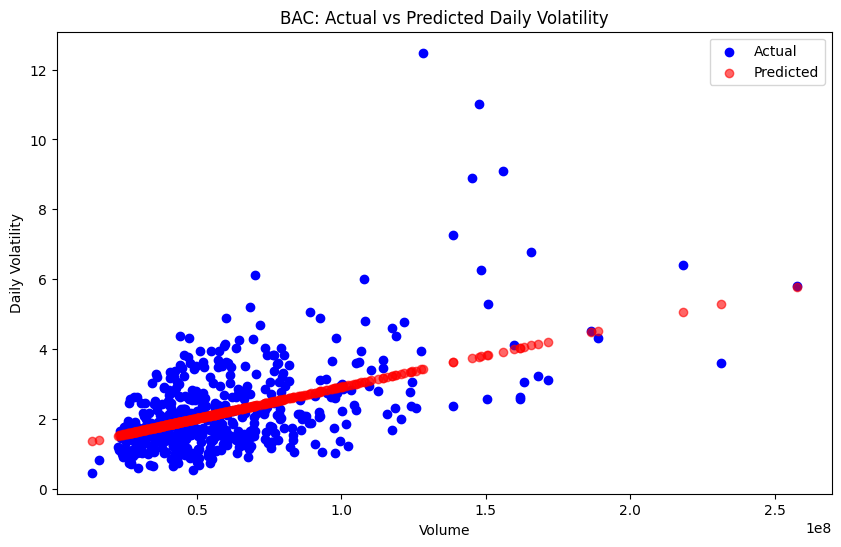

In [ ]:
# Plot actual vs predicted
plt.figure(figsize=(10,6))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_pred, color='red', alpha=0.6, label='Predicted')
plt.xlabel('Volume')
plt.ylabel('Daily Volatility')
plt.title('BAC: Actual vs Predicted Daily Volatility')
plt.legend()
plt.show()

Conclusion: Not really, though the result is better than return, Volume do have more impact on the volatility but still there so much other problems need considered